In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import resnet50
from torchvision import transforms
from torchvision import models

from matplotlib import pyplot as plt

from PIL import Image
import numpy as np
import json
import os

In [2]:
class MPIIDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_folder, 'mpii_human_pose_v1/images', self.data[idx]['img_paths'])
        image = Image.open(img_path).convert('RGB')
        joints = torch.tensor(self.data[idx]['joint_self'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        # Assuming that you have the necessary information to create targets
        # Modify this part according to your dataset structure and annotation format
        img_width = self.data[idx]["img_width"]
        img_height = self.data[idx]["img_height"]

        # Extract keypoints (x, y) from the annotation
        keypoints_x = joints[:, 0]
        keypoints_y = joints[:, 1]

        # Estimate bounding box around the person
        min_x = torch.min(keypoints_x)
        max_x = torch.max(keypoints_x)
        min_y = torch.min(keypoints_y)
        max_y = torch.max(keypoints_y)

        # Add a margin or scale factor if needed
        margin = 0.1
        min_x -= margin * (max_x - min_x)
        max_x += margin * (max_x - min_x)
        min_y -= margin * (max_y - min_y)
        max_y += margin * (max_y - min_y)

        # Clip to image boundaries
        min_x = max(min_x, 0)
        min_y = max(min_y, 0)
        max_x = min(max_x, img_width)
        max_y = min(max_y, img_height)

        # Convert to tensor
        boxes = torch.tensor([[min_x, min_y, max_x, max_y]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)  # Assuming a single class
        keypoints = torch.tensor(self.data[idx]['joint_self'], dtype=torch.float32)

        targets = {
            'boxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        return image, targets

    def load_data(self):
        json_path = os.path.join(self.data_folder, 'mpii_annotations.json')
        with open(json_path, 'r') as f:
            data = json.load(f)

        for entry in data:
            img_width = entry["img_width"]
            img_height = entry["img_height"]

            for temp in entry["joint_self"]:
                temp[0] = temp[0] / img_width
                temp[1] = temp[1] / img_height

            entry["objpos"] = (
                entry["objpos"][0] / img_width,
                entry["objpos"][1] / img_height
            )

            entry["img_width"] = 256
            entry["img_height"] = 256

        return data

In [3]:
# Define your own transformation if needed
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [12]:
# Provide the path to your dataset folder
data_folder = '/kaggle/input/mpii-human-pose/'

def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataset and data loader
mpi_dataset = MPIIDataset(data_folder, transform=transform)
mpi_dataloader = DataLoader(mpi_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [5]:
class MyModel(nn.Module):
    def __init__(self, isTraining=True):
        super(MyModel, self).__init__()

        # Load the pre-trained keypoints_resnet50_fpn model and freeze the weights
        self.training = isTraining
        self.backbone = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
#         print(self.backbone)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Initialize num_keypoints as a class attribute
        self.num_keypoints = 16  # Adjust the number of keypoints based on your task

        # Modify the last layer of the backbone
        in_channels = self.backbone.roi_heads.keypoint_head[-2].in_channels
        self.backbone.roi_heads.keypoint_head[-2] = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=512, kernel_size=3, stride=1, padding=1
        )
        self.backbone.roi_heads.keypoint_predictor.kps_score_lowres = nn.ConvTranspose2d(
            512, out_channels=self.num_keypoints, kernel_size=4, stride=2, padding=1
        )

    def forward(self, x, targets=None):
        outputs = self.backbone(x, targets)

        if self.training:
            # During training, return the relevant output and targets
            return {
                'loss_classifier': outputs['loss_classifier'],
                'loss_box_reg': outputs['loss_box_reg'],
                'loss_keypoint': outputs['loss_keypoint'],
            }
        else:
            # During inference, return the predicted keypoints
            # Post-process the outputs to match the expected format
            results = []
            for i, image_output in enumerate(outputs):
                result = {
                    'boxes': image_output['boxes'],
                    'labels': image_output['labels'],
                    'scores': image_output['scores'],
                    'keypoints': image_output['keypoints'][:, :, :3],  # Extract coordinates and visibility
                }
                results.append(result)
            return results

In [13]:
# Instantiate your model, loss function, and optimizer
model = MyModel()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.9, momentum=0.0, centered=False)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 1

In [ ]:
print(model)

In [15]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch_idx, (images, targets) in enumerate(mpi_dataloader):
        # Ensure that images and targets are on the same device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         person_float = transforms(images[0])

#         print("Number of Images in Batch:", len(images))
#         print("Image Shape of First Image:", images[0].shape)

        # Forward pass
        loss_dict = model(images, targets)
#         print(loss_dict)
        
        losses = sum(loss for loss in loss_dict.values())

        # Total loss
        total_loss = losses  # Add other losses if needed

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

        # Print statistics every 10 batches
        if batch_idx % 10 == 9:
            print(f"[Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(mpi_dataloader)}] Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

print("Training finished!")

[Epoch 1, Batch 10/788] Loss: 7.3888
[Epoch 1, Batch 20/788] Loss: 6.7468
[Epoch 1, Batch 30/788] Loss: 6.2681
[Epoch 1, Batch 40/788] Loss: 6.0929
[Epoch 1, Batch 50/788] Loss: 5.9731
[Epoch 1, Batch 60/788] Loss: 6.2886
[Epoch 1, Batch 70/788] Loss: 5.8667
[Epoch 1, Batch 80/788] Loss: 5.9694
[Epoch 1, Batch 90/788] Loss: 5.7393
[Epoch 1, Batch 100/788] Loss: 5.7356
[Epoch 1, Batch 110/788] Loss: 5.8150
[Epoch 1, Batch 120/788] Loss: 5.8267
[Epoch 1, Batch 130/788] Loss: 5.4923
[Epoch 1, Batch 140/788] Loss: 5.5142
[Epoch 1, Batch 150/788] Loss: 5.5722
[Epoch 1, Batch 160/788] Loss: 5.5578
[Epoch 1, Batch 170/788] Loss: 5.7171
[Epoch 1, Batch 180/788] Loss: 5.7553
[Epoch 1, Batch 190/788] Loss: 5.6593
[Epoch 1, Batch 200/788] Loss: 5.7238
[Epoch 1, Batch 210/788] Loss: 5.5210
[Epoch 1, Batch 220/788] Loss: 5.6053
[Epoch 1, Batch 230/788] Loss: 5.7452
[Epoch 1, Batch 240/788] Loss: 5.3440
[Epoch 1, Batch 250/788] Loss: 5.7162
[Epoch 1, Batch 260/788] Loss: 5.8509
[Epoch 1, Batch 270/7

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

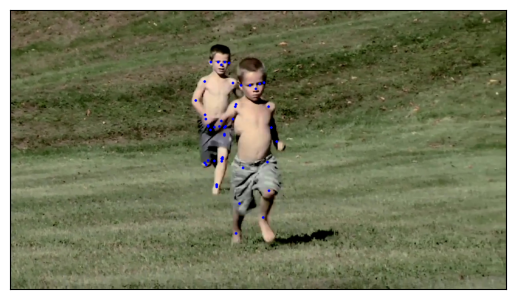

In [37]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_keypoints
from torchvision.io import read_image

person_int = read_image(str("/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/000001163.jpg"))

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

person_float = transforms(person_int).to(device)

model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
# model = torch.load('/kaggle/working/pythorch_test.pth').to(device)
model = model.eval().to(device)
outputs = model([person_float])

outputs

kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']

detect_threshold = 0
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

res = draw_keypoints(person_int, kpts, colors="blue", radius=3)
show(res)

In [ ]:
def visualize_batch_predictions(images, keypoints, predicted_keypoints, num_images=4, target_size=(256, 256)):
    """
    Visualize a batch of input images with ground truth and predicted keypoints.

    Args:
        images (Tensor): Batch of input image tensors.
        keypoints (Tensor): Batch of ground truth keypoints.
        predicted_keypoints (Tensor): Batch of predicted keypoints.
        num_images (int): Number of images to visualize.
        target_size (tuple): Target size for visualization (height, width).
    """
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])

    images_resized = torch.stack([transform(image) for image in images[:num_images].cpu()])
    keypoints = keypoints[:num_images].cpu().numpy()
    predicted_keypoints = predicted_keypoints[:num_images].cpu().detach().numpy()

    for i in range(num_images):
        plt.subplot(2, 2, i + 1)
        image = images_resized[i].permute(1, 2, 0).numpy()  # Convert image tensor to numpy array and change channel order
        plt.imshow(image)
        plt.scatter(keypoints[i, :, 0] * 256, keypoints[i, :, 1] * 256, s=10, c='r', marker='o', label='Ground Truth')
        plt.scatter(predicted_keypoints[i, :, 0] * 256, predicted_keypoints[i, :, 1] * 256, s=10, c='b', marker='o', label='Predicted')
        plt.title(f'Image {i + 1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Example usage:
# Assuming you have a batch of test images and their corresponding ground truth keypoints
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mpi_dataset = MPIIDataset(data_folder, transform=transform)
mpi_dataloader = DataLoader(mpi_dataset, batch_size=64, shuffle=True, num_workers=4)

batch_images, batch_ground_truth_keypoints = next(iter(mpi_dataloader))
batch_images = batch_images.to(device)
batch_ground_truth_keypoints = batch_ground_truth_keypoints.to(device)

# Forward pass to get model predictions
model.eval()
with torch.no_grad():
    batch_predicted_keypoints = model(batch_images)

# Visualize the predictions for the first four images in the batch
visualize_batch_predictions(batch_images, batch_ground_truth_keypoints, batch_predicted_keypoints)

In [ ]:
torch.save(model, 'pythorch_test.pth')